In [45]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/smoke.csv')
df.head()

Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  \
0           0  1654733331          20.000        57.36          0        400   
1           1  1654733332          20.015        56.67          0        400   
2           2  1654733333          20.029        55.96          0        400   
3           3  1654733334          20.044        55.28          0        400   
4           4  1654733335          20.059        54.69          0        400   

   Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  CNT  \
0   12306        18520        939.735    0.0    0.0    0.0    0.0    0.0    0   
1   12345        18651        939.744    0.0    0.0    0.0    0.0    0.0    1   
2   12374        18764        939.738    0.0    0.0    0.0    0.0    0.0    2   
3   12390        18849        939.736    0.0    0.0    0.0    0.0    0.0    3   
4   12403        18921        939.744    0.0    0.0    0.0    0.0    0.0    4   

   Fire Alarm  
0           0  
1           0  
2           0  
3           0  
4           0

# EDA

In [46]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'UTC', 'CNT'], axis=1)

In [47]:
# Checking the shape of the data
df.shape

(62630, 13)

In [48]:
# description of variables - this shows that there are no null values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature[C]  62630 non-null  float64
 1   Humidity[%]     62630 non-null  float64
 2   TVOC[ppb]       62630 non-null  int64  
 3   eCO2[ppm]       62630 non-null  int64  
 4   Raw H2          62630 non-null  int64  
 5   Raw Ethanol     62630 non-null  int64  
 6   Pressure[hPa]   62630 non-null  float64
 7   PM1.0           62630 non-null  float64
 8   PM2.5           62630 non-null  float64
 9   NC0.5           62630 non-null  float64
 10  NC1.0           62630 non-null  float64
 11  NC2.5           62630 non-null  float64
 12  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(5)
memory usage: 6.2 MB


In [49]:
# Although there are no missing values, let's confirm it
df.isnull().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

In [50]:
# Checking for any duplicacte records
print('Duplicates:', df.duplicated().sum())

Duplicates: 2


In [67]:
# Checking the distribution of target variable
print(df['Fire Alarm'].value_counts())
print(round(df['Fire Alarm'].value_counts(normalize=True)*100,2))

Fire Alarm
1    44757
0    17873
Name: count, dtype: int64
Fire Alarm
1    71.46
0    28.54
Name: proportion, dtype: float64


In [51]:
# Initializing X and y for training purposes
X = df.drop('Fire Alarm', axis=1)
y = df['Fire Alarm']

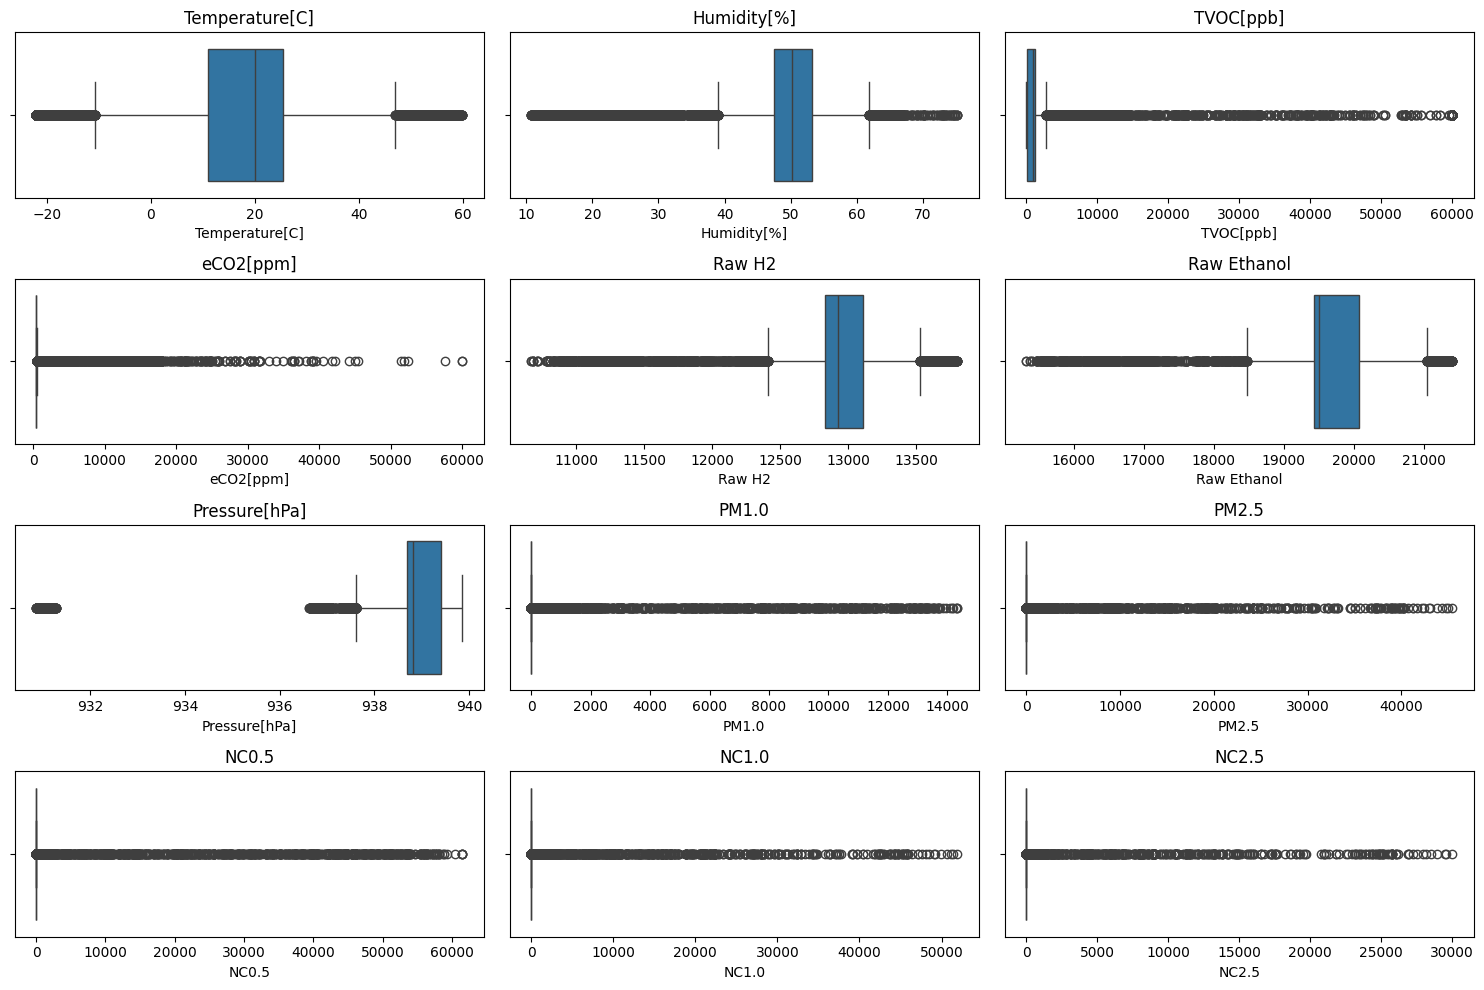

In [52]:
#Outlier Detection using Boxplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))

# All the features except the target variable
features = X.columns

# Boxplots
for i in range(len(features)):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x = features[i], data = X)
    plt.title(features[i])
plt.tight_layout()

As can be seen in the above boxplots, there are a lot of outliers. Since some classification algorithms are sensitive to outliers, let's handle them below

In [53]:
# Handling outliers
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1

# helper function to handle outliers using np.clip
def handle_outliers(df, col):
    lower_bound = q1[col] - 1.5*iqr[col]
    upper_bound = q1[col] + 1.5*iqr[col]

    # replacing values outside the bounds with the respective bounds
    df[col] = np.clip(df[col], lower_bound, upper_bound)

# Handling the outliers for every column in the dataset (except the target variable)
for feature in features:
    handle_outliers(X, feature)

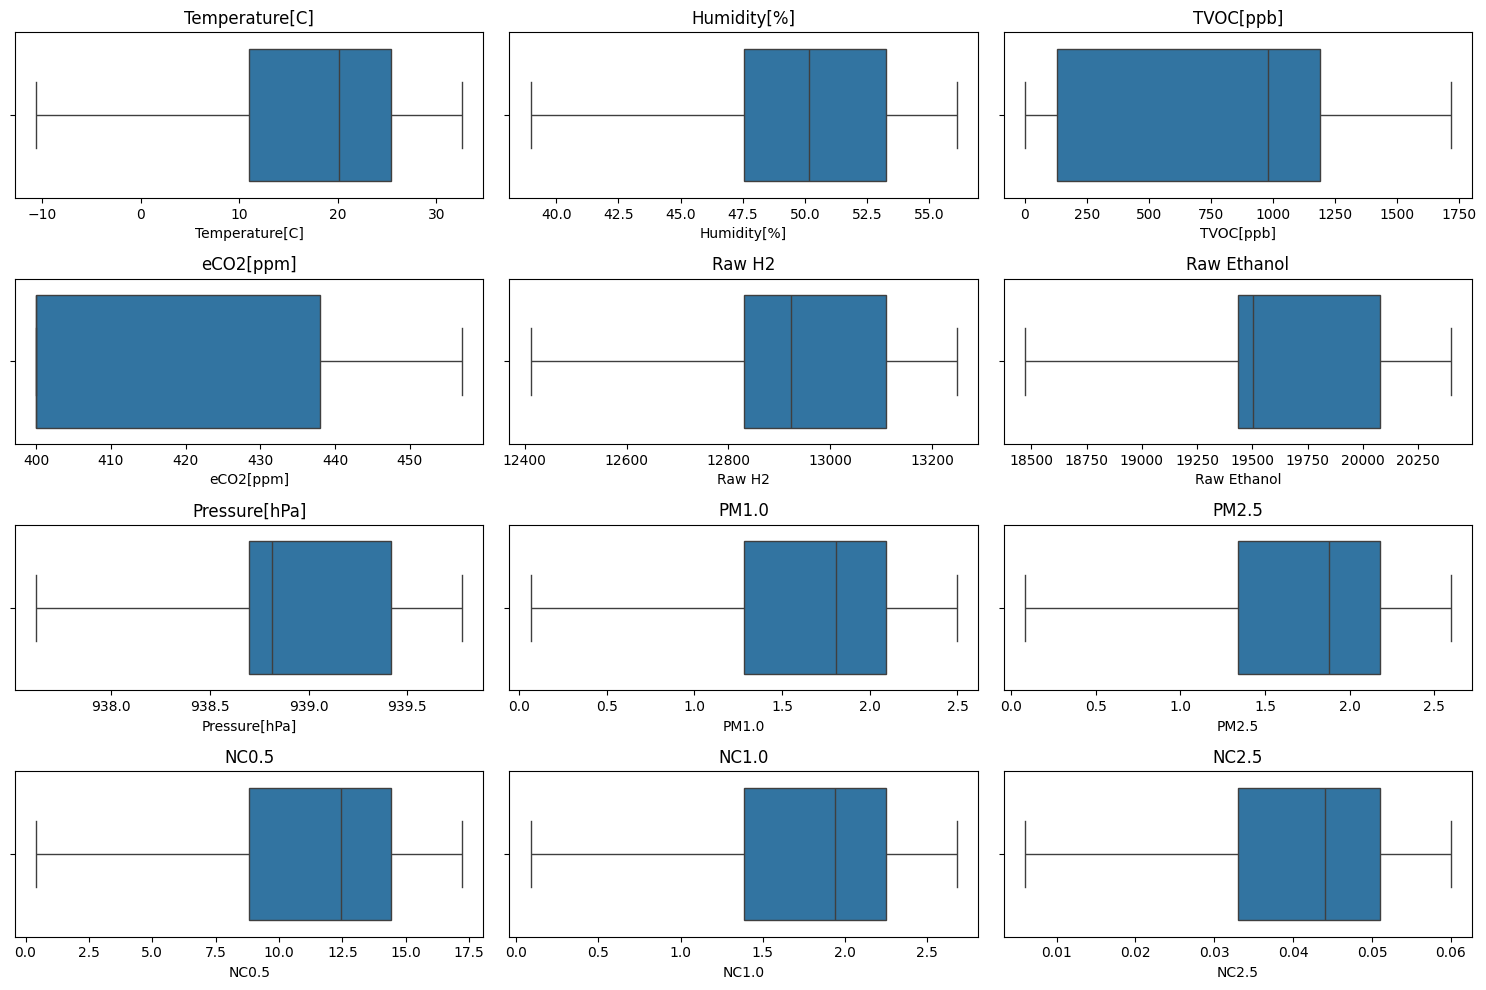

In [54]:
# Re-checking for outliers after handling them

#Outlier Detection using Boxplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))

# Boxplots
for i in range(len(features)):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x = features[i], data = X)
    plt.title(features[i])
plt.tight_layout()

As can be seen, the outliers are handled and the boxplots look clean

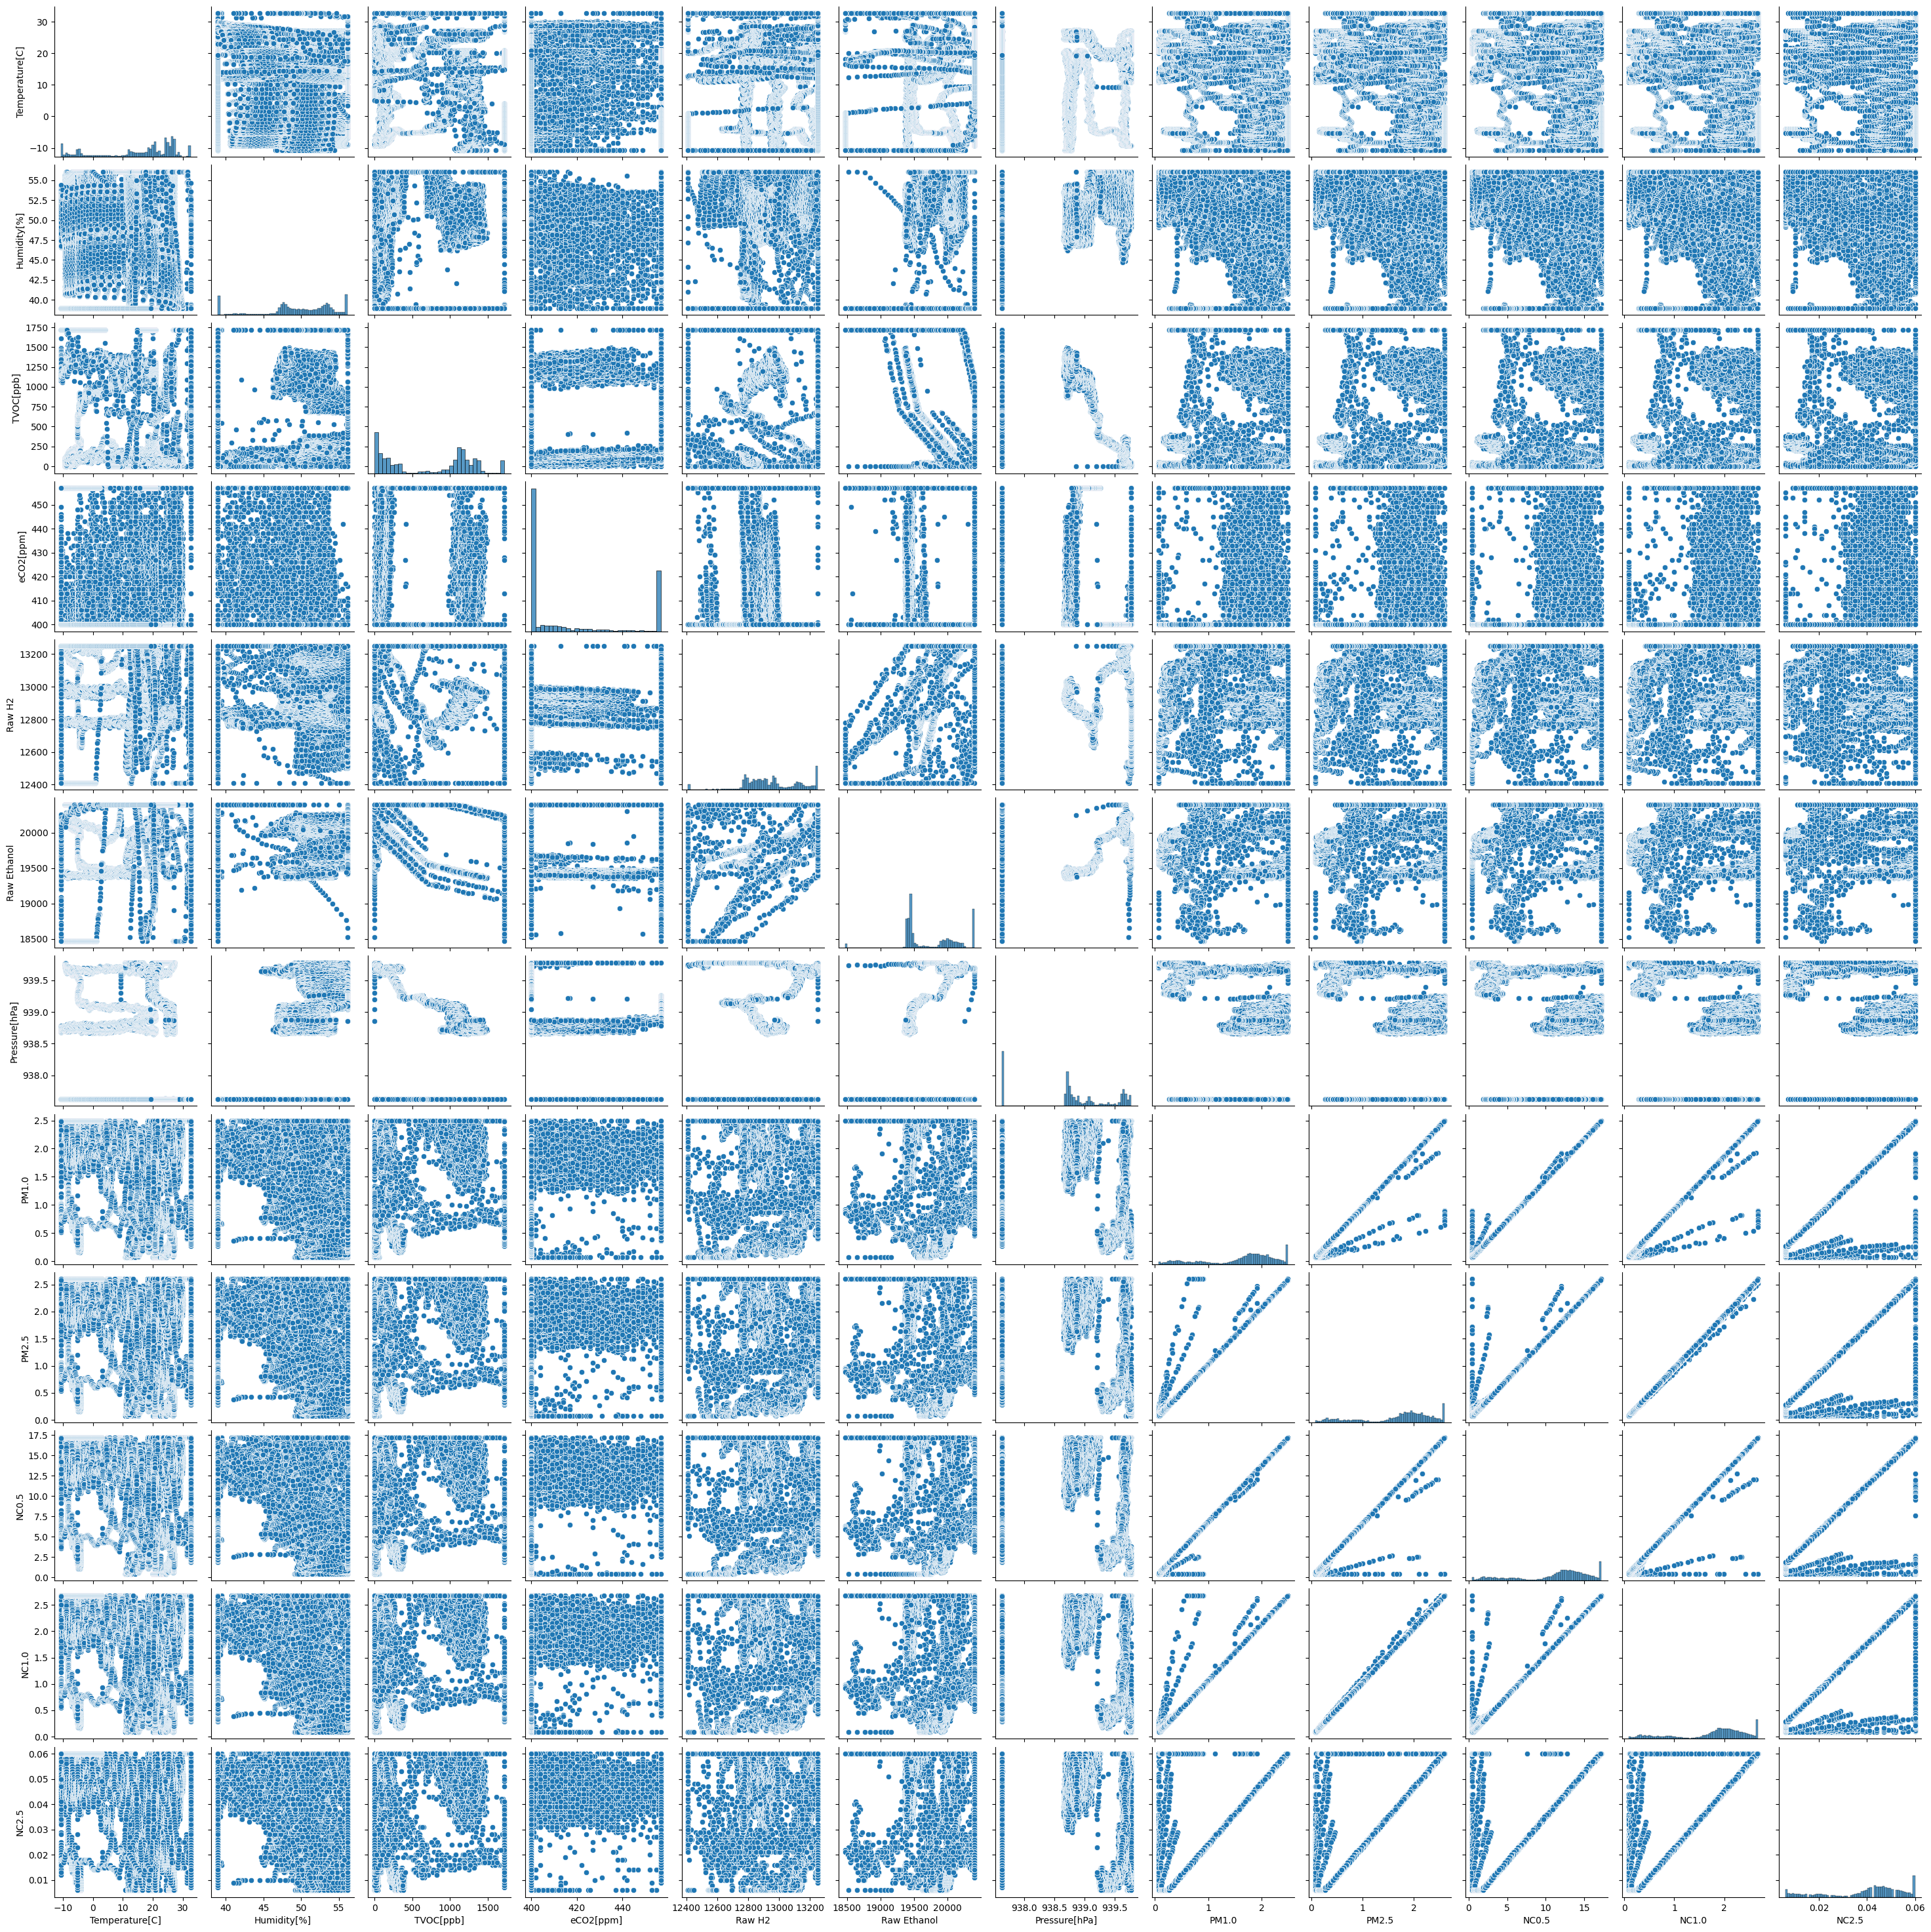

In [56]:
# Checking for correlation between the variables
sns.pairplot(X)

When checking for correlation, we're only focused on any linear relationships in the dataset between the variables. As can be seen in the above pairplot, linear relationships only occur in the bottom right of the plot, so we'll just focus on those features.

Now, let's check the same correlation with a heatmap

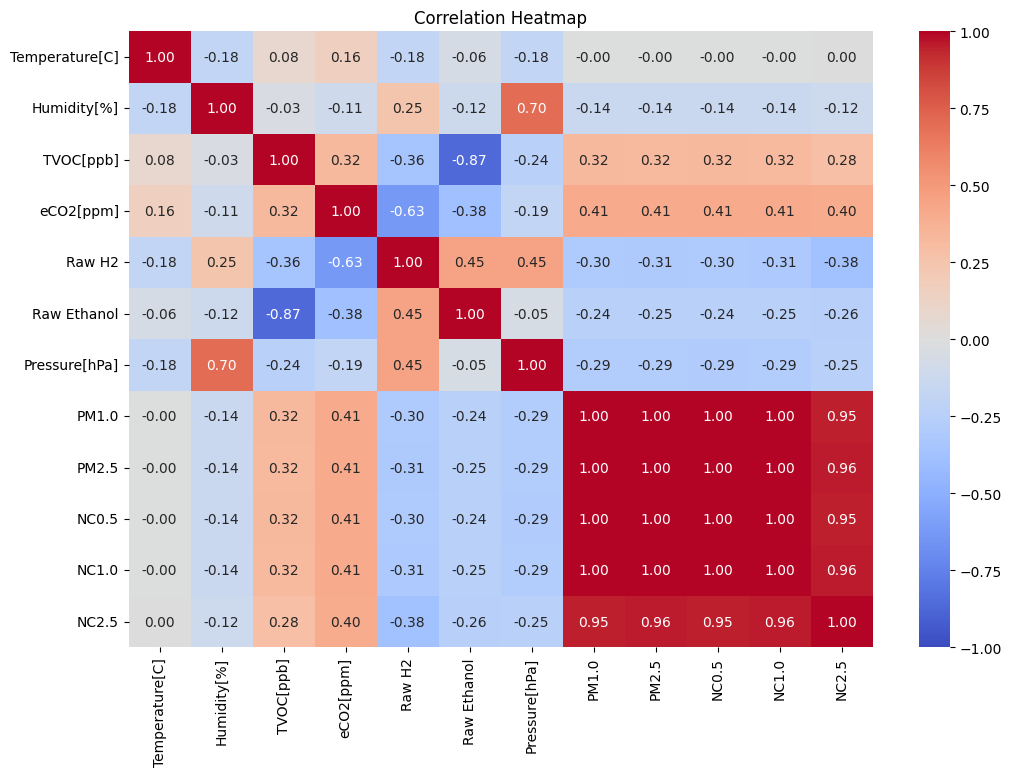

In [57]:
# Checking for correlations with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Again, as can be seen in the heatmap (just like in the pairplot), the correlation is strong among the features in the bottom right.

The strong linear relationship between two or more independent variables (which is true in this case) is a phenomenon called **multicollinearity**. 

And, the measure of how much multicollinearity is present in a regression model is called **Variance Inflation Factor (VIF)**

So since multicollinearity is clearly present in this dataset, let's handle it. We calculate VIF for every variable and eliminate the columns with highest VIUF

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif.sort_values(by='VIF', ascending=False))

           feature            VIF
8            PM2.5  205169.193548
7            PM1.0  184911.365903
10           NC1.0  167217.843188
9            NC0.5   99439.464688
6    Pressure[hPa]   23254.598477
4           Raw H2   12783.120327
5      Raw Ethanol   12072.123558
3        eCO2[ppm]     619.525027
1      Humidity[%]     155.358589
11           NC2.5     129.556556
2        TVOC[ppb]      13.052333
0   Temperature[C]       2.771927


As can be seen from the VIFs above, the top four features are the features in the bottom right part of the heatmap and pairplot which have the highest linear relationships. Hence theie VIF scores are high, proving multicollinearity. 

Usually the threshold for VIF is between 5 to 10, which means any variable with a VIF score of more than 5 or 10 should not be considered for classification. 

But in this case only Temperature has a VIF score of less than 5, we can't just eliminate all the other variables. Instead we will iteratively remove the variables from the top and re-check the VIF scores everytime we delete a variable. 

In [65]:
# Threshold foor VIF
max_vif = 5

# Intializing a flag to check if any of the variables are exceeding the VIF threshold
flag = True

while flag:
    vif = pd.DataFrame()
    vif['feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    # Finding the variable with the highest VIF
    max_vif_feature = vif.loc[vif['VIF'].idxmax()]

    if max_vif_feature['VIF'] > max_vif:
        # Removing the variable from X 
        X = X.drop(max_vif_feature['feature'], axis=1)
        print(f'Variable with high VIF (removed): {max_vif_feature["feature"]} {max_vif_feature["VIF"]}')
    else:
        # If no variable exceeds the threshold, set the flag to False
        flag = False

print('Final variables after handling multicollinearity', X.columns)

Final variables after handling multicollinearity Index(['Temperature[C]', 'TVOC[ppb]', 'NC0.5'], dtype='object')


In [66]:
X.shape

(62630, 3)

# Model Training

In [69]:
# Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
X_train.shape, X_test.shape

((50104, 3), (12526, 3))

In [71]:
X_train.head()

Temperature[C]  TVOC[ppb]  NC0.5
28479       21.430000      283.0   9.48
42605       25.980000     1247.0  11.88
17963       18.116000     1124.0  10.75
56394       32.617125     1718.5  17.22
29875       22.250000       24.0  15.47

In [ ]:
# Scaling the features
from sklearn.